### Topic Modelling - and more - with Gensim!

This tutorial will attempt to walk you through the entire process of analysing your text - from pre-processing to creating your topic models and visualising them. 

python offers a very rich suite of NLP and CL tools, and we will illustrate these to the best of our capabilities.
Let's start by setting up our imports.

We will be needing: 
```
- Gensim
- matplotlib
- spaCy
- pyLDAVis
```


In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001. 

We should keep in mind we can use pretty much any textual data-set and go ahead with what we will be doing.

In [2]:
# since we're working in python 2.7 in this tutorial, we need to make sure to clean our data to make it unicode consistent
def clean(text):
    return unicode(''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

### Pre-processing data!

It's been often said in Machine Learning and NLP algorithms - garbage in, garbage out. We can't have state-of-the-art results without data which is aa good. Let's spend this section working on cleaning and understanding our data set.
NTLK is usually a popular choice for pre-processing - but is a rather [outdated](https://explosion.ai/blog/dead-code-should-be-buried) and we will be checking out spaCy, an industry grade text-processing package. 

In [3]:
nlp = spacy.load("en")

For safe measure, let's add some stopwords. It's a newspaper corpus, so it is likely we will be coming across variations of 'said' and 'Mister' which will not really add any value to the topic models.

In [4]:
my_stop_words = [u'say', u'\'s', u'Mr', u'be', u'said', u'says', u'saying']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [5]:
doc = nlp(text)

Voila! With the `English` pipeline, all the heavy lifting has been done. Let's see what went on under the hood.

In [8]:
doc

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

It seems like nothing, right? But spaCy's internal data structure has done all the work for us. Let's see how we can create our corpus. You can check out what a gensim corpus looks like [here](google.com).

In [9]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. There's lot more we can do with spaCy which I would really recommend checking out.

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

In [10]:
bigram = gensim.models.Phrases(texts)

In [11]:
texts = [bigram[line] for line in texts]

In [12]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We're now done with a very important part of any text analysis - the data cleaning and setting up of corpus. It must be kept in mind that we created the corpus the way we did because that's how gensim requires it - most algorithms still require one to clean the data set the way we did, by removing stop words and numbers, adding the lemmatized form of the word, and using bigrams. 

### LSI

LSI stands for Latent Semantic Indeixing - it is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [13]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [14]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.240*"israeli" + 0.215*"Arafat" + 0.199*"palestinian" + 0.175*"force" + 0.159*"official" + 0.159*"kill" + 0.152*"attack" + 0.141*"people" + 0.118*"day" + 0.117*"Israel"'),
 (1,
  '-0.311*"israeli" + -0.299*"Arafat" + -0.271*"palestinian" + 0.161*"Afghanistan" + -0.160*"Sharon" + 0.159*"Australia" + -0.153*"Israel" + -0.127*"Hamas" + -0.121*"West_Bank" + 0.116*"day"'),
 (2,
  '-0.258*"Afghanistan" + -0.222*"force" + 0.187*"fire" + -0.186*"Al_Qaeda" + -0.176*"bin_Laden" + -0.155*"Pakistan" + 0.148*"Sydney" + -0.134*"fighter" + -0.132*"Tora_Bora" + -0.121*"Taliban"'),
 (3,
  '-0.374*"fire" + -0.271*"area" + 0.213*"Australia" + -0.200*"Sydney" + -0.173*"firefighter" + -0.158*"north" + -0.149*"wind" + -0.135*"Wales" + -0.135*"New_South" + -0.131*"south"'),
 (4,
  '0.273*"company" + 0.209*"Qantas" + 0.180*"union" + -0.152*"win" + 0.149*"worker" + -0.139*"match" + -0.134*"South_Africa" + -0.127*"wicket" + -0.119*"test" + -0.118*"day"')]

### HDP

HDP, the Hierarchical Dirichlet process is an unsupervised topic model which figures out the number of topics on it's own.

In [15]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [16]:
hdpmodel.show_topics()

[(0,
  '0.003*airport + 0.003*Taliban + 0.003*kill + 0.002*area + 0.002*hit + 0.002*force + 0.002*leader + 0.002*Kandahar + 0.002*source + 0.002*israeli + 0.002*soldier + 0.002*storm + 0.002*arrest + 0.002*night + 0.002*opposition + 0.002*Sydney + 0.002*city + 0.002*people + 0.002*militant + 0.002*damage'),
 (1,
  '0.003*Afghanistan + 0.003*India + 0.002*Powell + 0.002*southern + 0.002*Taliban + 0.002*President + 0.002*great + 0.002*Rabbani + 0.002*troop + 0.001*near + 0.001*force + 0.001*report + 0.001*reject + 0.001*security_force + 0.001*Rumsfeld + 0.001*export + 0.001*leader + 0.001*United_States + 0.001*power + 0.001*ground'),
 (2,
  '0.004*storm + 0.002*tree + 0.002*help + 0.002*Sydney + 0.002*Government + 0.002*work + 0.002*call + 0.002*large + 0.002*hit + 0.002*assistance + 0.002*Lew + 0.002*home + 0.002*bring + 0.002*Los + 0.002*service + 0.002*bid + 0.001*area + 0.001*business + 0.001*Snyder + 0.001*SES'),
 (3,
  '0.003*palestinian + 0.003*group + 0.003*Government + 0.003*Sha

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [17]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [18]:
ldamodel.show_topics()

[(0,
  '0.005*"people" + 0.004*"report" + 0.004*"take" + 0.003*"day" + 0.003*"second" + 0.003*"start" + 0.003*"South_Africa" + 0.003*"Australia" + 0.003*"year" + 0.003*"think"'),
 (1,
  '0.006*"Qantas" + 0.005*"fire" + 0.004*"company" + 0.003*"people" + 0.003*"year" + 0.003*"union" + 0.003*"pay" + 0.003*"day" + 0.003*"come" + 0.003*"Australia"'),
 (2,
  '0.006*"people" + 0.005*"Afghanistan" + 0.003*"kill" + 0.003*"official" + 0.003*"man" + 0.003*"Australia" + 0.003*"force" + 0.003*"rise" + 0.002*"israeli" + 0.002*"United_States"'),
 (3,
  '0.005*"people" + 0.004*"day" + 0.004*"force" + 0.004*"new" + 0.004*"area" + 0.003*"Australian" + 0.003*"Australia" + 0.003*"United_States" + 0.003*"company" + 0.003*"Afghanistan"'),
 (4,
  '0.005*"day" + 0.003*"Hamas" + 0.003*"child" + 0.003*"end" + 0.003*"think" + 0.003*"fire" + 0.003*"staff" + 0.003*"tell" + 0.003*"force" + 0.003*"Pakistan"'),
 (5,
  '0.008*"year" + 0.005*"force" + 0.005*"Australia" + 0.004*"fire" + 0.003*"claim" + 0.003*"come" + 0

### pyLDAvis 

Thanks to pyLDAvis, we can visualise our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [19]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.012873  0.024743       1        1  20.227974
6      0.007949 -0.052384       2        1  19.077059
9      0.014553  0.027771       3        1  11.055172
0     -0.008150 -0.036619       4        1   9.349201
1     -0.063648  0.022643       5        1   8.309767
4      0.035141 -0.013682       6        1   8.103770
5      0.020994  0.057189       7        1   7.983943
7     -0.059585 -0.024308       8        1   6.708514
8      0.042294 -0.030045       9        1   6.317052
2      0.023327  0.024691      10        1   2.867547, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
846   Default   85.000000        israeli   85.000000  30.0000  30.0000
2387  Default   30.000000         Qantas   30.000000  29.0000  29.0000
308   Default   61.000000    Afghanistan   61.000000  28.0000  28.0000
853   Default   69.000000    palestinian   69.000000  27.0000  27.0000
2197  Default   59.000000         Arafat   59.000000  26.0000  26.0000
82    Default  109.000000         people  109.000000  25.0000  25.0000
201   Default   93.000000           year   93.000000  24.0000  24.0000
120   Default   36.000000       Pakistan   36.000000  23.0000  23.0000
3240  Default   15.000000            HIH   15.000000  22.0000  22.0000
59    Default   89.000000          force   89.000000  21.0000  21.0000
221   Default   95.000000            day   95.000000  20.0000  20.0000
1025  Default   67.000000            man   67.000000  19.0000  19.0000
56    Default   67.000000           fire   67.000000  18.0000  18.0000
833   Default   38.000000          Hamas   38.000000  17.0000  17.0000
924   Default   29.000000           test   29.000000  16.0000  16.0000
2393  Default   40.000000          union   40.000000  15.0000  15.0000
2358  Default   63.000000        company   63.000000  14.0000  14.0000
144   Default   17.000000         indian   17.000000  13.0000  13.0000
685   Default   70.000000       official   70.000000  12.0000  12.0000
310   Default  114.000000      Australia  114.000000  11.0000  11.0000
679   Default   66.000000           kill   66.000000  10.0000  10.0000
893   Default   70.000000         report   70.000000   9.0000   9.0000
170   Default   53.000000           take   53.000000   8.0000   8.0000
27    Default   65.000000           area   65.000000   7.0000   7.0000
3464  Default   27.000000         Sharon   27.000000   6.0000   6.0000
1030  Default   16.000000           rise   16.000000   5.0000   5.0000
333   Default   48.000000          claim   48.000000   4.0000   4.0000
34    Default   54.000000           call   54.000000   3.0000   3.0000
128   Default   77.000000         attack   77.000000   2.0000   2.0000
112   Default   30.000000          India   30.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
82    Topic10    4.790987         people  109.423462   0.4232  -5.1501
147   Topic10    1.671022         launch   17.510637   1.2023  -6.2034
1335  Topic10    0.935304        Vaughan    6.690032   1.5842  -6.7837
2680  Topic10    0.577038    Ministerial    2.718742   2.0017  -7.2667
1327  Topic10    0.645426      Antarctic    3.401368   1.8897  -7.1547
679   Topic10    2.614799           kill   66.127090   0.3213  -5.7556
562   Topic10    1.417340           mean   18.188271   0.9997  -6.3681
685   Topic10    2.550530       official   70.708275   0.2295  -5.7805
324   Topic10    1.710933        Taliban   31.293354   0.6453  -6.1798
285   Topic10    1.369826       hospital   19.425690   0.8998  -6.4022
1025  Topic10    2.324378            man   67.449547   0.1838  -5.8734
1809  Topic10    1.102714           land   12.154953   1.1518  -6.6191
1978  Topic10    1.260307       Kandahar   18.174175   0.8831  -6.4855
196   Topic10    1.445673         remain   

### Round-up

Okay - so what have we learned so far? 
By using spaCy, we cleaned up our data super fast. It's worth noting that by running our doc through the pipeline we also know about every single words POS-tag and NER-tag. This is useful information and we can do some funky things with it! I would highly recommend going through [this](https://github.com/explosion/spacy-notebooks) repository to see examples of hands-on spaCy usage.

As for gensim and topic modelling, it's pretty easy to see how well we could create our topic models. Now the obvious next question is - how do we use these topic models? The [news classification notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb) in the Gensim [notebooks](https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks) directory is a good example of how we can use topic models in a practical scenario.

We will continue this tutorial by demonstrating a newer topic modelling features of gensim - in particular, Topic Coherence. 

### Topic Coherence

Topic Coherence is a new gensim functionality where we can identify which topic model is 'better'. 
By returning a score, we can compare between different topic models of the same. We use the same example from the news classification notebook to plot a graph between the topic models we have created.

In [18]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [19]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [20]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

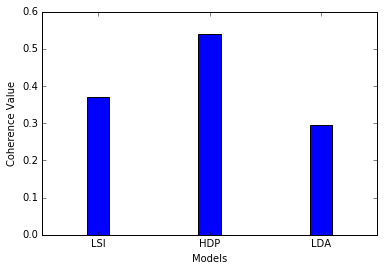

In [21]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

We can see that topic coherence helped us get past manually inspecting our topic models - we can now keep fine tuning our models and compare between them to see which has the best performance. 

This also brings us to the end of the runnable part of this tutorial - we will continue however by briefly going over two more Jupyter notebooks I have previously worked on - mainly, [Dynamic Topic Modelling](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) and [Document Word Coloring](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb).